# Lesson 13.4 Dead ReLU Problem与学习率优化

&emsp;&emsp;和Sigmoid、tanh激活函数不同，ReLU激活函数的叠加并不会出现梯度消失或者梯度爆炸，但ReLU激活函数中使得部分数值归零的特性却会导致另外一个严重的问——Dead ReLU Problem，也被称为神经元活性失效问题。

## 一、Dead ReLU Problem成因分析

### 1.Dead ReLU Problem直接表现

&emsp;&emsp;首先我们通过实验来观察神经元活性失效问题（Dead ReLU Problem）在建模过程中的直接表现。其实在上一节中，最后出现的ReLU叠加模型在迭代多次后在MSE取值高位收敛的情况，其实就是出现了神经元活性失效所导致的问题

In [1]:
# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1], bias=False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)

In [2]:
# 创建随机数种子
torch.manual_seed(420)  

# 实例化模型
relu_model3 = ReLU_class3(bias=False)              # 为了更方便的观察神经元活性失效问题，我们创建不带截距项的模型

# 核心参数
num_epochs = 20
lr = 0.03

观察模型训练结果

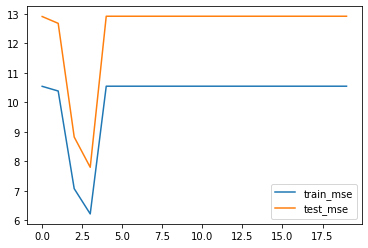

In [3]:
# 模型训练
train_l, test_l = model_train_test(relu_model3, 
                                   train_loader,
                                   test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = 0.03, 
                                   cla = False, 
                                   eva = mse_cal)

# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_l, label='train_mse')
plt.plot(list(range(num_epochs)), test_l, label='test_mse')
plt.legend(loc = 4)

我们发现，模型在迭代多轮之后，训练误差和测试误差都在各自取值的高位收敛了，也就是误差不随模型迭代测试增加而递减。通过简单尝试我们不难发现，此时模型对所有数据的输出结果都是0。

In [4]:
relu_model3(features)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

### 2.Dead ReLU Problem成因分析

#### 2.1 Dead ReLU Problem基本判别

&emsp;&emsp;神经元活性失效问题和ReLU激活函数本身特性有关。首先，我们观察ReLU激活函数函数图像与导函数图像。

In [121]:
# 绘制ReLU函数的函数图像和导函数图像
X = torch.arange(-5, 5, 0.1)
X.requires_grad=True
relu_y = torch.relu(X)

In [122]:
# 反向传播
relu_y.sum().backward()

<AxesSubplot:>

Text(0.5, 1.0, 'ReLU Function')

<AxesSubplot:>

Text(0.5, 1.0, 'ReLU Derivative function')

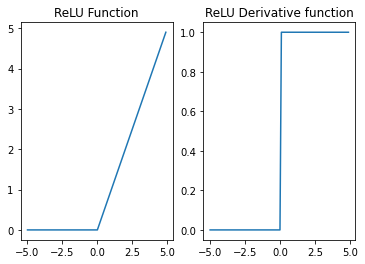

In [123]:
# ReLU函数图像
plt.subplot(121)
plt.plot(X.detach(), relu_y.detach())
plt.title("ReLU Function")
# ReLU导函数图像
plt.subplot(122)
plt.plot(X.detach(), X.grad.detach())
plt.title("ReLU Derivative function")

对于ReLU激活函数来说，只要激活函数接收到的数据小于0，输出结果就全是0，并且更关键的是，只要ReLU输出结果是0，由于ReLU的导函数是分段常数函数且接收数据为负时导数为0，因此如果ReLU输出结果为零，则反向传播结果、也就是各层的梯度，也都是零。

我们进一步通过举例说明，现在有模型基本结构如下

<img src="https://i.loli.net/2021/02/23/cld8x7RSXbhZDN2.jpg" alt="62" style="zoom:40%;" />

设w1为第一层传播的权重，w2为第二层传播的权重，并且w1的第一列对应连接隐藏层第一个神经元的权重，w1的第二列对应连接隐藏层第二个神经元的权重，f为输入的特征张量，并且只有一条数据

In [255]:
w1 = torch.tensor([[0., 0], [-1, -2]], requires_grad = True)
w1

tensor([[ 0.,  0.],
        [-1., -2.]], requires_grad=True)

In [256]:
w2 = torch.tensor([1., -1]).reshape(-1, 1)
w2.requires_grad = True
w2

tensor([[ 1.],
        [-1.]], requires_grad=True)

In [257]:
f = torch.tensor([[1, 2.]])
f

tensor([[1., 2.]])

第一次向前传播过程如下：

In [258]:
# 线性变换
f2 = torch.mm(f, w1)
f2

tensor([[-2., -4.]], grad_fn=<MmBackward>)

In [259]:
# 激活函数处理
f3 = torch.relu(f2)
f3

tensor([[0., 0.]], grad_fn=<ReluBackward0>)

In [260]:
# 输出结果
out = torch.mm(f3, w2)
out

tensor([[0.]], grad_fn=<MmBackward>)

l为f的真实标签，则损失函数和反向传播过程如下：

In [261]:
l = torch.tensor([[3.]])
l

tensor([[3.]])

In [262]:
loss = F.mse_loss(out, l)

In [263]:
loss

tensor(9., grad_fn=<MseLossBackward>)

In [264]:
loss.backward()

而此时w1、w2的梯度如下：

In [265]:
w1.grad
w2.grad

tensor([[0., 0.],
        [0., 0.]])

tensor([[0.],
        [0.]])

我们发现，当某条数据在模型中的输出结果为0时，反向传播后各层参数的梯度也全为0，此时参数将无法通过迭代更新。而进一步的，如果在某种参数情况下，整个训练数据集输入模型之后输出结果都是0，则在小批量梯度下降的情况下，每次再挑选出一些数据继续进行迭代，仍然无法改变输出结果是0的情况，此时参数无法得到更新、进而下次输入的小批数据结果还是零、从而梯度为0、从而参数无法更新...至此陷入死循环，模型失效、激活函数失去活性，也就出现了Dead ReLU Problem。

当然，上述过程可以由如下数学过程说明，假设模型预测值:$$\hat y = ReLU(X * w_1) * w_2$$

并且，出现Dead ReLU Problem的时候，某一组$w_1$恰好使得ReLU输出结果为0，因此$\hat y = 0$，而此时损失函数为：

$$loss = MSE = \frac{\sum ((\hat y - y) ^ 2)}{N} $$

根据链式法则，此时梯度为：$$
\begin{aligned}
grad &= ( \frac{\partial loss}{\partial w_1}, \frac{\partial loss}{\partial w_2}) \\
&= (\frac{\partial loss}{\partial \hat y} \frac{\partial \hat y}{\partial w_1}, \frac{\partial loss}{\partial \hat y} \frac{\partial \hat y}{\partial w_2})\\
\end{aligned}
$$

由于$\hat y$恒为0（为一个常量），由ReLU激活函数导函数特性可知，$\hat y$对任何自变量偏导也为0，此时grad也就为0，$w_1、w_2$不会再更新。而参数不更新，$\hat y$仍然为0，梯度还是为0，如此往复，就出现了上述死循环，也就是Dead ReLU Problem。

#### 2.2 Dead ReLU Problem发生概率

当然，我们也可略微进行一些拓展。试想以下，出现Dead ReLU Problem问题的概率，其实是伴随ReLU层的增加而增加的。如果是两层ReLU层，模型结构如下：

<center><img src="https://i.loli.net/2021/02/24/9g1tykm8djrPKQN.jpg" alt="63" style="zoom:35%;" />

向前传播过程中，模型输出结果为：

$$\hat y = ReLU(ReLU(X * w_1) * w_2) * w_3$$

不难发现，在两层ReLU嵌套的情况下，$\hat y$取值为0的概率就更大了，出现Dead ReLU Problem的概率也就更高了。而同时，根据各层参数的梯度计算公式我们也能够发现，只要其中任意一层输出结果是0，则所有层参数的梯度均为0。

$$
grad_1 
= \frac{\partial loss}{\partial \hat y} 
\cdot 
w_3 \cdot f(F(X*w_1)*w_2) \cdot
w_2 \cdot f(X * w_1) \cdot X 
$$

$$
grad_2 
= \frac{\partial loss}{\partial \hat y} 
\cdot 
w_3 \cdot f(F(X*w_1)*w_2) \cdot
F(X * w_1) 
$$

$$
grad_3 = \frac{\partial loss}{\partial \hat y} 
\cdot 
F(F(X * w_1) * w_2)
$$

最终，我们可以通过如下表达式判别ReLU激活函数是否失效

In [8]:
train_loader.dataset[:][0]

tensor([[-1.4463, -0.6221],
        [-0.4742, -0.2939],
        [ 1.9870,  0.1949],
        ...,
        [-1.6366, -2.1399],
        [-1.8178, -1.4618],
        [ 0.2646,  2.3555]])

In [125]:
relu_model3(train_loader.dataset[:][0])

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [11]:
(relu_model3(train_loader.dataset[:][0]) == 0).sum()

tensor(700)

> 当然，如果模型是带入偏差进行的建模，出现Dead ReLU Problem的时候模型输出结果恒为bias的取值。

## 二、通过调整学习率缓解Dead ReLU Problem

&emsp;&emsp;在所有的解决Dead ReLU Problem的方法中，最简单的一种方法就是调整学习率。尽管我们知道，ReLU叠加越多层越容易出现神经元活性失效，但我们可以简单通过降低学习率的方法来缓解神经元活性失效的问题。甚至可以说这是一种通用且有效的方法。      
&emsp;&emsp;学习率作为模型重要的超参数，会在各方面影响模型效果，此前我们曾介绍学习率越小、收敛速度就越慢，而学习率过大、则又容易跳过最小值点造成模型结果震荡。对于ReLU激活函数来说，参数“稍有不慎”就容易落入输出值全为0的陷阱，因此训练过程需要更加保守，采用更小的学习率逐步迭代。当然学习率减少就必然需要增加迭代次数，但由于ReLU激活函数计算过程相对简单，增加迭代次数并不会显著增加计算量。      

Text(0.5, 1.0, 'lr=0.03')

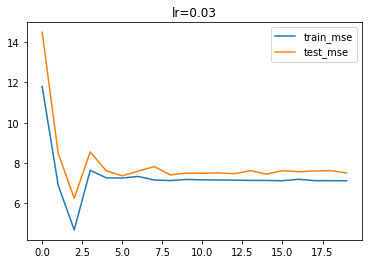

In [12]:
# 设置随机数种子
torch.manual_seed(420)  

# 核心参数
num_epochs = 20
lr = 0.03

# 实例化模型
relu_model3 = ReLU_class3()

# 模型训练
train_l, test_l = model_train_test(relu_model3, 
                                   train_loader,
                                   test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_l, label='train_mse')
plt.plot(list(range(num_epochs)), test_l, label='test_mse')
plt.title('lr=0.03')
plt.legend(loc = 1)

Text(0.5, 1.0, 'lr=0.001')

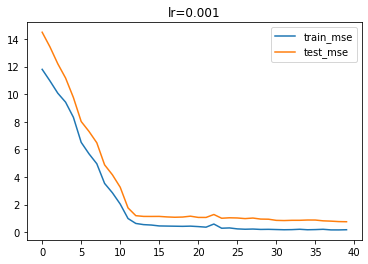

In [13]:
# 设置随机数种子
torch.manual_seed(420)  

# 核心参数
num_epochs = 40
lr = 0.001

# 实例化模型
relu_model3 = ReLU_class3()

# 模型训练
train_l, test_l = model_train_test(relu_model3, 
                                   train_loader,
                                   test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_l, label='train_mse')
plt.plot(list(range(num_epochs)), test_l, label='test_mse')
plt.title('lr=0.001')
plt.legend(loc = 1)

我们发现学习率调小之后，模型更能够避开神经元活性失效陷阱。关于更多学习率调整策略，我们会在后续完整介绍。

## 三、ReLU激活函数特性理解

&emsp;&emsp;至此，我们也可以进一步理解ReLU激活函数的实际作用。可以这么说，ReLU激活函数的实际作用是“选择性更新部分参数”，回顾上述公式，我们不难发现，当激活函数是ReLU激活函数时，以上述例子为例，无论是第一层接收到的数值（$X*w_1$)小于0，还是第二层接收到的数值（$F(X*w_1)*w_2$)小于0，都会导致三层参数的梯度为0，同时，哪怕是第一层接收到的数据全是0，也会导致所有参数本轮不被更新。而在实际深度学习建模过程中，我们是采用小批量梯度下降算法来进行梯度计算，而如果某一批的数据输出结果为0，则当前迭代结束时参数不变，也就相当于模型采用了“有选择”的数据进行参数更新——只“选择”了那些输出结果不为0的数据进行参数训练。同时我们需要知道的是，这一轮某一批数据没被选择，不代表下一轮这批数据仍然不被选择（因为参数会变化，因而输出结果也会发生变化），因此我们可以理解为每一轮都带入不同数据进行参数训练，从而最终完成模型训练。

&emsp;&emsp;并且，从梯度消失和梯度爆炸角度考虑，ReLU激活函数拥有更加优异的特性。我们都知道，ReLU激活函数的导函数取值要么是1要么是0，当导函数取值为1时，能够保证各层参数的梯度在计算时不受因层数变化而累乘的导函数影响（因为导函数取值都为1）。

> 值得注意的是，每次带入不同批次数据训练，或者说每次有选择性的忽略部分数据，就相当于进行了“非线性”的变换。

> 关于“随机性”的作用，其实我们已经见过很多次了，在集成模型中，我们将在一定随机性条件下构建的、彼此不同的基分类器进行集成，从而创建一个效果明显好于单个基分类器的集成模型；在SGD中，我们采用每次带入随机部分数据的方法进行梯度下降迭代，从而使得迭代过程能够跳出局部最小值点；而在ReLU激活函数中，我们随机挑选部分参数进行迭代，从而完成数据的“非线性”转化，进而保证模型本身的有效性。

> 也正因如此，ReLU激活函数也被称为非饱和激活函数

我们可以观察上一节模型训练结束后各层参数的梯度

In [9]:
# 观察各层梯度
for m in relu_model3.modules():
    if isinstance(m, nn.Linear):
        print(m.weight.grad)

tensor([[-1.2105, -1.1560],
        [-1.2854,  0.4011],
        [ 0.5821,  0.9778],
        [ 1.2699,  1.5803]])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [-1.7618, -0.2564,  0.1256, -4.4533],
        [ 0.7966,  0.1120,  0.6588,  2.0890]])
tensor([[ 0.0000,  0.0000,  0.6559,  0.4969],
        [ 0.0000,  0.0000,  0.7240,  0.5485],
        [ 0.0000,  0.0000, -0.7708, -0.5839],
        [ 0.0000,  0.0000, -0.7633, -0.5783]])
tensor([[-0.3015, -0.4115, -0.5745, -0.5258]])


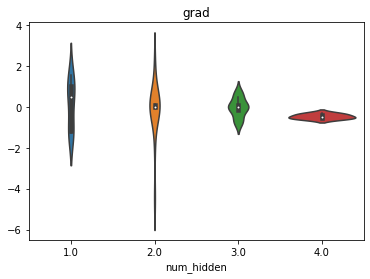

In [10]:
weights_vp(relu_model3, att="grad")

能够看出，模型各层仍然处在学习状态，虽然存在梯度不均的状态，但在学习率非常小的情况下整体表现仍然较为平稳。不过需要注意的是，对于ReLU激活函数来说，每一层梯度分布的小提琴图会很大程度受到梯度0值的影响，并且每一次迭代完成后是否取0值都会发生变化，从而影响小提琴图对真实情况反应的准确程度。

## 四、nn.Sequential快速建模方法及nn.init模型参数自定义方法

&emsp;&emsp;在讨论如何解决上述激活函数叠加问题之前，我们先补充两个基础工具，其一是使用nn.Sequential进行模型的快速构建，其二则是使用nn.init来进行模型参数修改。其中关于模型参数修改的相关方法，也是支撑本节优化方法实践的核心。

### 1.nn.Sequential快速建模方法介绍

&emsp;&emsp;首先补充关于使用nn.Sequential进行快速建模的方法介绍。在此前的建模环节，我们都是通过完整的创建模型类、通过定义init方法和forward方法来确定模型的基本结构、传播方式和激活函数。除了这种模型定义方法外，PyTorch还支持使用nn.Sequential来快速，在借助nn.Sequential进行模型构建过程中，我们只需要将每一层神经元连接方法和激活函数作为参数输入nn.Sequential即可，具体流程如下：

In [62]:
# 设置随机数种子
torch.manual_seed(25)

# 构建上述LR_ReLU_test模型
relu_test = nn.Sequential(nn.Linear(2, 2, bias=False), nn.ReLU(), nn.Linear(2, 1, bias=False))

在上述模型定义过程中，relu_test相当于已经实例化之后的模型

In [63]:
list(relu_test.parameters())

[Parameter containing:
 tensor([[ 0.3561, -0.4343],
         [-0.6182,  0.5823]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1658, -0.2843]], requires_grad=True)]

而此时的实例化，是nn.Sequential类的实例化，也就是说，通过nn.Sequential创建的模型本质上都是nn.Sequential的一个实例。

In [64]:
isinstance(relu_test, nn.Sequential)

True

In [65]:
# 而此前创建的模型都是我们所创建的类的实例
isinstance(relu_model3, ReLU_class3)

True

而上述`nn.Sequential`所创建的模型结构，就相当于是两层全连接神经网络，并且隐藏层使用ReLU进行处理。其中需要注意的是，nn.ReLU()单独使用时就相当于ReLU函数，而放在nn.Sequential中就等价于对某一层的输出结果进行ReLU处理。

In [66]:
r1 = nn.ReLU()

In [67]:
t = torch.tensor([1., -1])
t

tensor([ 1., -1.])

In [68]:
r1(t)

tensor([1., 0.])

In [69]:
torch.relu(t)

tensor([1., 0.])

当然，通过nn.Sequential定义的模型也可以执行向前传播过程

In [79]:
f = torch.tensor([[1, 2.]], requires_grad = True)
f

tensor([[1., 2.]], requires_grad=True)

In [80]:
relu_test.forward(f)

tensor([[-0.1553]], grad_fn=<MmBackward>)

我们可以手动验证

In [76]:
w1 = list(relu_test.parameters())[0].t()         # 第一层传播参数
w1

tensor([[ 0.3561, -0.6182],
        [-0.4343,  0.5823]], grad_fn=<TBackward>)

In [81]:
w2 = list(relu_test.parameters())[1].t()         # 第二层传播参数
w2

tensor([[-0.1658],
        [-0.2843]], grad_fn=<TBackward>)

In [85]:
torch.mm(torch.relu(torch.mm(f, w1)), w2)

tensor([[-0.1553]], grad_fn=<MmBackward>)

当然，如果进一步将rele的参数手动设置为此前设置的w1和w2，就可以复现ReLU激活函数的活性失效例子。那如何才能在手动修改模型参数值呢？我们将在下面一小节进行补充。

总而言之，我们不难发现，利用nn.Sequential进行模型创建在模型结构相对简单时可以大幅减少代码量，并且模型效果和先通过定义类、再进行实例化的模型效果相同，但该方法在定义高度复杂的模型、或者定义更加灵活的模型时就显得力不从心了。因此，对于新手，推荐先掌握利用类定义模型的方法，再掌握利用nn.Sequential定义模型的方法。

### 2.模型参数自定义方法

&emsp;&emsp;接下来，继续补充关于手动设置模型初始参数及模型参数共享的方法。首先，对于模型参数来说，parameters返回结果是个生成器（generator），通过list转化后会生成一个由可微张量构成的list。

- 通过修改可微张量方法修改参数

In [107]:
relu_test.parameters()

<generator object Module.parameters at 0x0000020B2BB0F148>

In [95]:
list(relu_test.parameters())

[Parameter containing:
 tensor([[ 0.3561, -0.4343],
         [-0.6182,  0.5823]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1658, -0.2843]], requires_grad=True)]

In [111]:
list(relu_test.parameters())[0]

Parameter containing:
tensor([[ 0.3561, -0.4343],
        [-0.6182,  0.5823]], requires_grad=True)

因此，我们可以通过修改可微张量数值的方法对其进行修改。在Lesson 12中，我们介绍了三种修改可微张量数值的方法，这里我们直接使用.data的方法对其进行修改：

In [198]:
# 修改目标
w1 = torch.tensor([[0., 0], [-1, -2]])
w2 = torch.tensor([1., -1]).reshape(-1, 1)
w1
w2

tensor([[ 0.,  0.],
        [-1., -2.]])

tensor([[ 1.],
        [-1.]])

In [199]:
list(relu_test.parameters())[0].data = w1.t()

In [200]:
list(relu_test.parameters())[1].data = w2.t()

In [201]:
# 查看修改结果
list(relu_test.parameters())

[Parameter containing:
 tensor([[ 0., -1.],
         [ 0., -2.]], requires_grad=True),
 Parameter containing:
 tensor([[ 1., -1.]], requires_grad=True)]

然后即可执行向前传播

In [202]:
f = torch.tensor([[1, 2.]])
f

tensor([[1., 2.]])

In [203]:
# 模型输出结果
out = relu_test.forward(f)
out

tensor([[0.]], grad_fn=<MmBackward>)

In [206]:
# 真实标签
l = torch.tensor([[3.]])
l

tensor([[3.]])

接下来计算损失函数

In [207]:
loss = F.mse_loss(out, l)
loss

tensor(9., grad_fn=<MseLossBackward>)

进行反向传播

In [208]:
loss.backward()

查看模型参数梯度

In [211]:
list(relu_test.parameters())[0].grad

tensor([[0., 0.],
        [0., 0.]])

In [212]:
list(relu_test.parameters())[1].grad

tensor([[0., 0.]])

至此也验证了和此前手动实现的相同结果。

- 使用init方法创建满足某种分布的参数

&emsp;&emsp;除了通过手动方法修改参数值以外，我们还可以使用nn.init方法来对模型参数进行修改。

In [15]:
# 重新设置初始化模型参数取值
# 设置随机数种子
torch.manual_seed(25)

# 构建上述LR_ReLU_test模型
relu_test = nn.Sequential(nn.Linear(2, 2, bias=False), nn.ReLU(), nn.Linear(2, 1, bias=False))

In [16]:
list(relu_test.parameters())

[Parameter containing:
 tensor([[ 0.3561, -0.4343],
         [-0.6182,  0.5823]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1658, -0.2843]], requires_grad=True)]

(1).nn.init.uniform_方法，新生成的参数服从均匀分布

In [17]:
nn.init.uniform_(relu_test.parameters(), 0, 1)   

AttributeError: 'generator' object has no attribute 'uniform_'

In [18]:
list(relu_test.parameters())[0]

Parameter containing:
tensor([[ 0.3561, -0.4343],
        [-0.6182,  0.5823]], requires_grad=True)

In [219]:
nn.init.uniform_(list(relu_test.parameters())[0], 0, 1)        # 设置参数值为均匀分布在0，1区间内的随机数

Parameter containing:
tensor([[0.0481, 0.3497],
        [0.3520, 0.9528]], requires_grad=True)

当然，和此前一样，带有下划线的函数都是能够直接修改对象本身的

In [22]:
list(relu_test.parameters())[0]

Parameter containing:
tensor([[0.0481, 0.3497],
        [0.3520, 0.9528]], requires_grad=True)

(2).nn.init.normal_方法，新生成的参数服从正态分布

In [221]:
nn.init.normal_(list(relu_test.parameters())[0], 0, 1)        # 服从均值为0、标准差为1的正态分布

Parameter containing:
tensor([[ 0.0827,  0.5799],
        [ 0.0578, -0.2979]], requires_grad=True)

就相当于手动修改，然后使用size参数，最后需要令其可导并替换原始参数值。

In [36]:
torch.normal(0, 1, size = list(relu_test.parameters())[0].size())

tensor([[-1.5217,  0.6919],
        [ 0.8875, -0.3946]])

(3).nn.init.constant_方法，新生成的参数值为某一常数

In [222]:
nn.init.constant_(list(relu_test.parameters())[0], 1)        # 参数全为1

Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

和下述表达式等效，然后再令其可导并替换原始参数值。

In [41]:
torch.full_like(list(relu_test.parameters())[0], 1)

tensor([[1., 1.],
        [1., 1.]])

&emsp;&emsp;当然，上述过程并不复杂，并且相同的修改目标，使用手动方式也能实现。对于nn.init方法来说，最核心的使用场景是能够创建服从特殊分布、具备一定特性的、能够辅助模型迭代收敛的初始参数。相关方法我们将在下一小节详细介绍。      